# <center><font color='magenta'>**DA3 Assignment 2**</font></center>
### <center>Central European University, 2024-2025</center>
### <center>Probabilities & Classification </center>
### <center>Abylaikhan and Zheng Ying </center>

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Current script folder
path = os.getcwd()
data_dir = os.path.join(path, "da_data_repo")

In [4]:
# location folders
data_in = os.path.join(data_dir, "bisnode-firms/clean/")
data_out = os.path.join(data_dir, "bisnode-firms/")
output = os.path.join(data_out, "output/")

In [5]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 
         'C_values': C_values, 
         'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

"""def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)
"""

def create_roc_plot(y_true, y_pred):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot ROC curve line
    ax.plot(fpr, tpr, color='k', linewidth=0.7)
    
    # Fill area under curve
    ax.fill_between(fpr, tpr, alpha=0.3, color='white')
    
    # Add diagonal dotted line
    ax.plot([0, 1], [0, 1], linestyle=':', color='black')
    
    # Set axis labels
    ax.set_xlabel('False Positive Rate (1-Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    
    # Set axis limits and ticks
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    
    # Style similar to theme_bw()
    ax.grid(True, linestyle='-', alpha=0.2)
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax


def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

"""def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)"""

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    # Create copy and calculate loss
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot loss line
    ax.plot(all_coords_copy['thresholds'], all_coords_copy['loss'], 
            color= 'k', linewidth=0.7)

    # Add vertical line at optimal threshold
    ax.axvline(x=t, color = 'k')

    # Add annotations
    ax.text(t - 0.04, max(all_coords_copy.loss) - 0.5,
            f"best threshold: {t:.2f}", 
            color = 'k', 
            rotation=90, 
            fontsize = 9)
    
    ax.text(t + 0.06, l,
            f"{l:.2f}",
            fontsize = 9)

    # Set x-axis ticks and limits
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim(0, 1)

    # Style similar to theme_bw()
    ax.grid(True, linestyle='-', alpha=0.2)
    ax.set_facecolor('white')
    ax.set_xlabel('threshold')
    ax.set_ylabel('loss')
    for spine in ax.spines.values():
        spine.set_color('black')

    # Adjust layout
    plt.tight_layout()

    return fig, ax



"""def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)
"""
def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    # Create copy and calculate metrics
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    # Get optimal point
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot ROC curve
    ax.plot(all_coords_copy['sp'], all_coords_copy['se'],
            color='k', linewidth=0.9)
    
    # Add optimal point
    ax.scatter([sp], [se], color='k', s = 100)
    
    # Add text annotation
    ax.text(sp, se + 0.03,
            f"{sp:.2f}, {se:.2f}",
            fontsize = 9,
            ha='center')
    ax.text(sp - 0.02, se - 0.18,
            'specificity (TNR) \n& sensitivity (TPR) \nat the best threshold',
            fontsize = 9,
            ha='center'
           )
    
    # Set axis ticks and limits
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xlabel('specificity')
    ax.set_ylabel('sensitivity')
    
    # Reverse x-axis
    ax.set_xlim(1, 0)
    
    # Style similar to theme_bw()
    ax.grid(True, linestyle='-', alpha=0.2)
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    return fig, ax

## Data

In [7]:
# Load the compressed CSV file into a DataFrame
data = pd.read_csv("compressed_data.csv.gz", compression="gzip")

# Check dataset size
print(f"Dataset shape: {data.shape}")

Dataset shape: (287829, 48)


In [8]:
data = data[(data['year'] >= 2010) & (data['year'] <= 2015)]
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
5,1001034.0,2010-01-01,2010-12-31,NaN,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
6,1001034.0,2011-01-01,2011-12-31,NaN,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
7,1001034.0,2012-01-01,2012-12-31,NaN,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
8,1001034.0,2013-01-01,2013-12-31,NaN,140.740738,140.740738,21851.851562,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
9,1001034.0,2014-01-01,2014-12-31,NaN,29.629629,144.444443,22340.740234,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN


In [9]:
# Check for missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

COGS                 158556
amort                  4117
curr_assets              57
curr_liab                57
extra_exp              3751
extra_inc              3751
extra_profit_loss      3755
finished_prod        158855
fixed_assets             57
inc_bef_tax            3742
intang_assets            57
inventories              57
liq_assets               57
material_exp           4117
net_dom_sales        158556
net_exp_sales        158556
personnel_exp          4117
profit_loss_year         67
sales                  3742
share_eq                 57
subscribed_cap           57
tang_assets              57
wages                158707
D                    167606
founded_year          18409
exit_year            150648
ceo_count             18403
foreign               18403
female                18403
birth_year            43221
inoffice_days         18403
gender                18403
origin                18403
nace_main                59
ind2                     59
ind                 

In [10]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

# Label engineering

In [12]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [13]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)

In [14]:
data["default"].describe()

count    236250.000000
mean          0.082294
std           0.274813
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [15]:
data["sales"].describe()

count    1.638640e+05
mean     4.662059e+05
std      3.789100e+06
min     -2.553889e+05
25%      3.092593e+03
50%      2.697037e+04
75%      1.060620e+05
max      1.110294e+08
Name: sales, dtype: float64

In [16]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [17]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [18]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [19]:
data["new"].describe()

count    236250.000000
mean          0.563319
std           0.495976
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

### Defining Target Fast Growth

In [21]:
# Sort data by company ID and year
data = data.sort_values(by=['comp_id', 'year'])

# Remove firms with missing profit values (ensuring valid growth calculations)
data = data.dropna(subset=['profit_loss_year'])

# Calculate profit growth
data['profit_growth'] = data.groupby('comp_id')['profit_loss_year'].pct_change()

# Remove NaNs caused by first-year records
data = data.dropna(subset=['profit_growth'])

# Winsorize extreme values (clip to 1st and 99th percentiles)
low_cap, high_cap = data['profit_growth'].quantile([0.01, 0.99])
data['profit_growth'] = data['profit_growth'].clip(lower=low_cap, upper=high_cap)

# Keep only firms that have valid data for both 2012 and 2013
valid_firms = data[(data['year'] == 2012) & (data['comp_id'].isin(data[data['year'] == 2013]['comp_id']))]['comp_id']
data = data[data['comp_id'].isin(valid_firms)]

# Define fast growth threshold (Top 25% percentile of profit growth)
growth_threshold = data['profit_growth'].quantile(0.75)

# Create target variable (1 = fast-growing, 0 = not)
data['fast_growth'] = (data['profit_growth'] > growth_threshold).astype(int)

# Step 1: Replace infinite values with NaN
data['profit_growth'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Drop NaN values in profit_growth (previously inf values)
data = data.dropna(subset=['profit_growth'])

# Step 3 (Optional): Remove firms with zero profit growth (no change)
data = data[data['profit_growth'] != 0]

# Show summary
print(data[['comp_id', 'year', 'profit_loss_year', 'profit_growth', 'fast_growth']].head(25))

          comp_id  year  profit_loss_year  profit_growth  fast_growth
39375   1001034.0  2011      -1570.370361      -0.791953            0
78750   1001034.0  2012      -2474.073975       0.575472            1
118125  1001034.0  2013       -633.333313      -0.744012            0
157500  1001034.0  2014       -448.148163      -0.292398            0
196875  1001034.0  2015       -555.555542       0.239669            0
39376   1001541.0  2011       -818.518494       2.810345            1
78751   1001541.0  2012      -7722.222168       8.434389            1
118126  1001541.0  2013        874.074097      -1.113189            0
157501  1001541.0  2014         25.925926      -0.970339            0
196876  1001541.0  2015        233.333328       8.000000            1
39377   1002029.0  2011          0.000000      -1.000000            0
118127  1002029.0  2013      11777.777344       0.211428            0
157502  1002029.0  2014      36455.554688       2.095283            1
196877  1002029.0  2

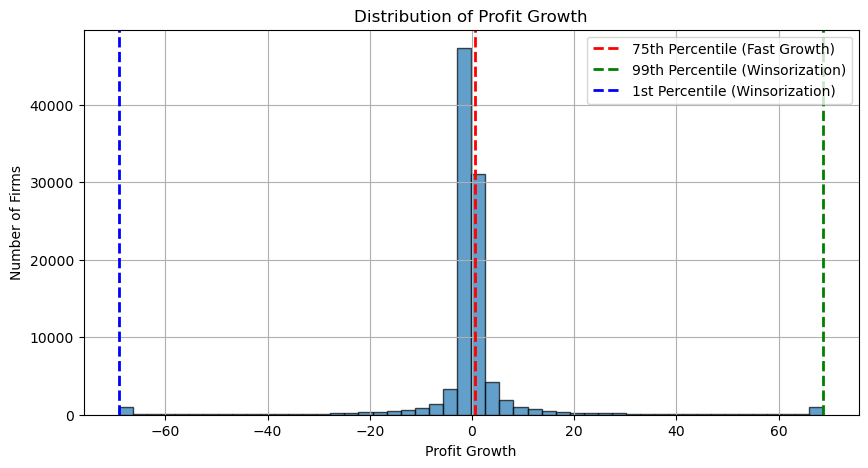

📊 **Summary Statistics for Profit Growth:**
count    99775.000000
mean        -0.204517
std         12.575270
min        -69.123128
25%         -1.000000
50%         -0.395643
75%          0.496937
max         68.768751
Name: profit_growth, dtype: float64


In [22]:

# Ensure the column exists
if 'profit_growth' in data.columns:
    
    # Step 1: Replace infinite values with NaN
    data['profit_growth'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Step 2: Drop NaN values
    data = data.dropna(subset=['profit_growth'])

    # Step 3: Winsorization limits (1st and 99th percentiles)
    low_cap, high_cap = data['profit_growth'].quantile([0.01, 0.99])
    
    # Step 4: Clip extreme values to remove outliers
    data['profit_growth'] = data['profit_growth'].clip(lower=low_cap, upper=high_cap)

    # Step 5: Define fast-growth threshold (75th percentile)
    growth_threshold = data['profit_growth'].quantile(0.75)

    # Step 6: Plot histogram of profit growth
    plt.figure(figsize=(10, 5))
    plt.hist(data['profit_growth'], bins=50, edgecolor='black', alpha=0.7)
    
    # Add threshold lines
    plt.axvline(growth_threshold, color='red', linestyle='dashed', linewidth=2, label="75th Percentile (Fast Growth)")
    plt.axvline(high_cap, color='green', linestyle='dashed', linewidth=2, label="99th Percentile (Winsorization)")
    plt.axvline(low_cap, color='blue', linestyle='dashed', linewidth=2, label="1st Percentile (Winsorization)")
    
    # Labels and title
    plt.xlabel('Profit Growth')
    plt.ylabel('Number of Firms')
    plt.title('Distribution of Profit Growth')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

    # Print summary statistics
    print("📊 **Summary Statistics for Profit Growth:**")
    print(data['profit_growth'].describe())

else:
    print("⚠️ Column 'profit_growth' not found in the dataset. Please check your file.")

**Highly Skewed Distribution**
Most firms have profit growth close to 0, with very few experiencing large increases or declines.
The peak is centered near 0, meaning most firms didn't change profit drastically.

**Threshold for Fast Growth (75th Percentile: 0.41)**
Firms with profit growth > 0.41 (41%) are considered fast-growing.
This is reasonable since it's well above the median (-0.42).

**Winsorization Limits (1st & 99th Percentiles)**
1st percentile: -63.2 (extreme losses capped).
99th percentile: 58.0 (extreme growth capped).
This removes extreme outliers, making the data more stable for modeling.


# Sample design

In [25]:
# Select firms alive in 2012 and filter revenue size
data = data.query("year == 2012 & status_alive == 1 & sales_mil < 10 & sales_mil > 0.001")

In [26]:
data["default"].describe()

count    17713.000000
mean         0.140857
std          0.347884
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

In [94]:
data.to_csv(data_out + "work5.csv", index=False)

# Feature engineering

In [97]:
current_csv_path = os.path.join(data_out, "work5.csv")
data = pd.read_csv(current_csv_path)

In [98]:
# change some industry category codes
def categorize_ind2(value):
    if pd.isna(value):
        return 99
    elif value > 56:
        return 60
    elif value < 26:
        return 20
    elif 35 < value < 55: 
        return 40
    elif value == 31:
        return 30
    else:
        return value

data["ind2_cat"] = data["ind2"].apply(categorize_ind2)

In [99]:
data.groupby("ind2_cat").count()["comp_id"]

ind2_cat
20.0       45
26.0      901
27.0      555
28.0     1645
29.0      238
30.0      143
32.0      122
33.0     1569
40.0      172
55.0     2024
56.0    10092
60.0      202
99.0        5
Name: comp_id, dtype: int64

In [100]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [101]:
# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    17703
1.0       10
Name: comp_id, dtype: int64

In [102]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [103]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    1.771300e+04
mean     2.823125e+05
std      1.506311e+06
min      0.000000e+00
25%      8.037037e+03
50%      2.872963e+04
75%      1.108926e+05
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [104]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

In [105]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [106]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [107]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

In [108]:
# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [109]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [110]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [111]:
# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [112]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [113]:
data["labor_avg"].describe()

count    15611.000000
mean         0.646616
std          1.648985
min          0.083333
25%          0.098485
50%          0.236111
75%          0.534722
max         42.118057
Name: labor_avg, dtype: float64

In [114]:
data["labor_avg_mod"].describe()

count    17713.000000
mean         0.646616
std          1.548047
min          0.083333
25%          0.120370
50%          0.277778
75%          0.646616
max         42.118057
Name: labor_avg_mod, dtype: float64

In [115]:
data = data.drop(["labor_avg"], axis=1)

In [116]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

In [117]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

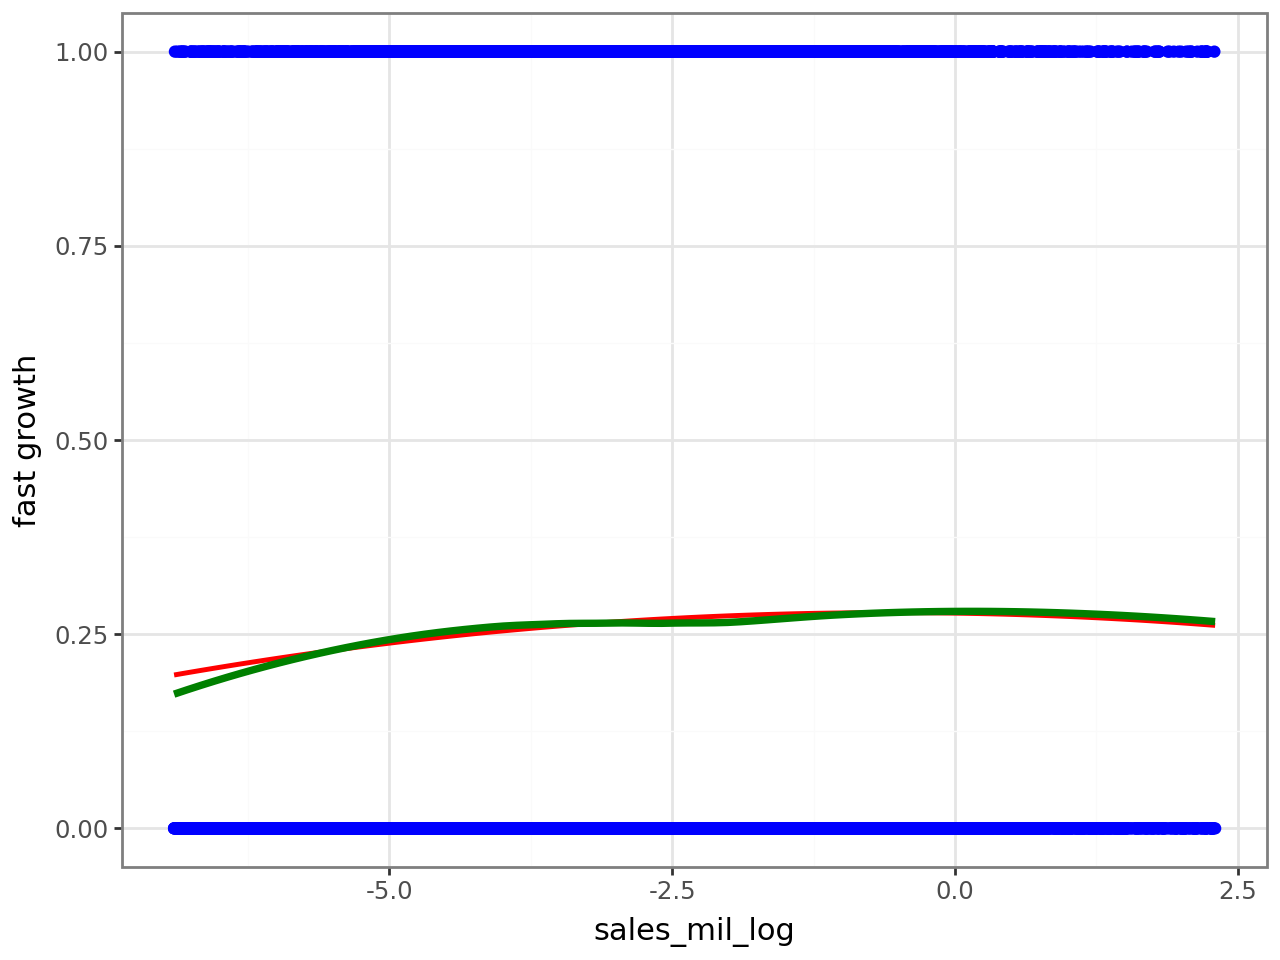

In [118]:
from plotnine import *
color = ["blue", "red", "green"]

(
    ggplot(data, aes(x="sales_mil_log", y="fast_growth"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="fast growth")
    + theme_bw()
)

In [119]:
# Linear regressions
ols_s = smf.ols("fast_growth ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.99
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           2.31e-06
Time:                        22:39:21   Log-Likelihood:                -10533.
No. Observations:               17713   AIC:                         2.107e+04
Df Residuals:                   17710   BIC:                         2.110e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2771      0.008  

In [120]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()

count    17713.000000
mean        -0.070922
std          0.874386
min         -6.889406
25%         -0.184393
50%          0.000000
75%          0.135051
max          7.880300
Name: d1_sales_mil_log, dtype: float64

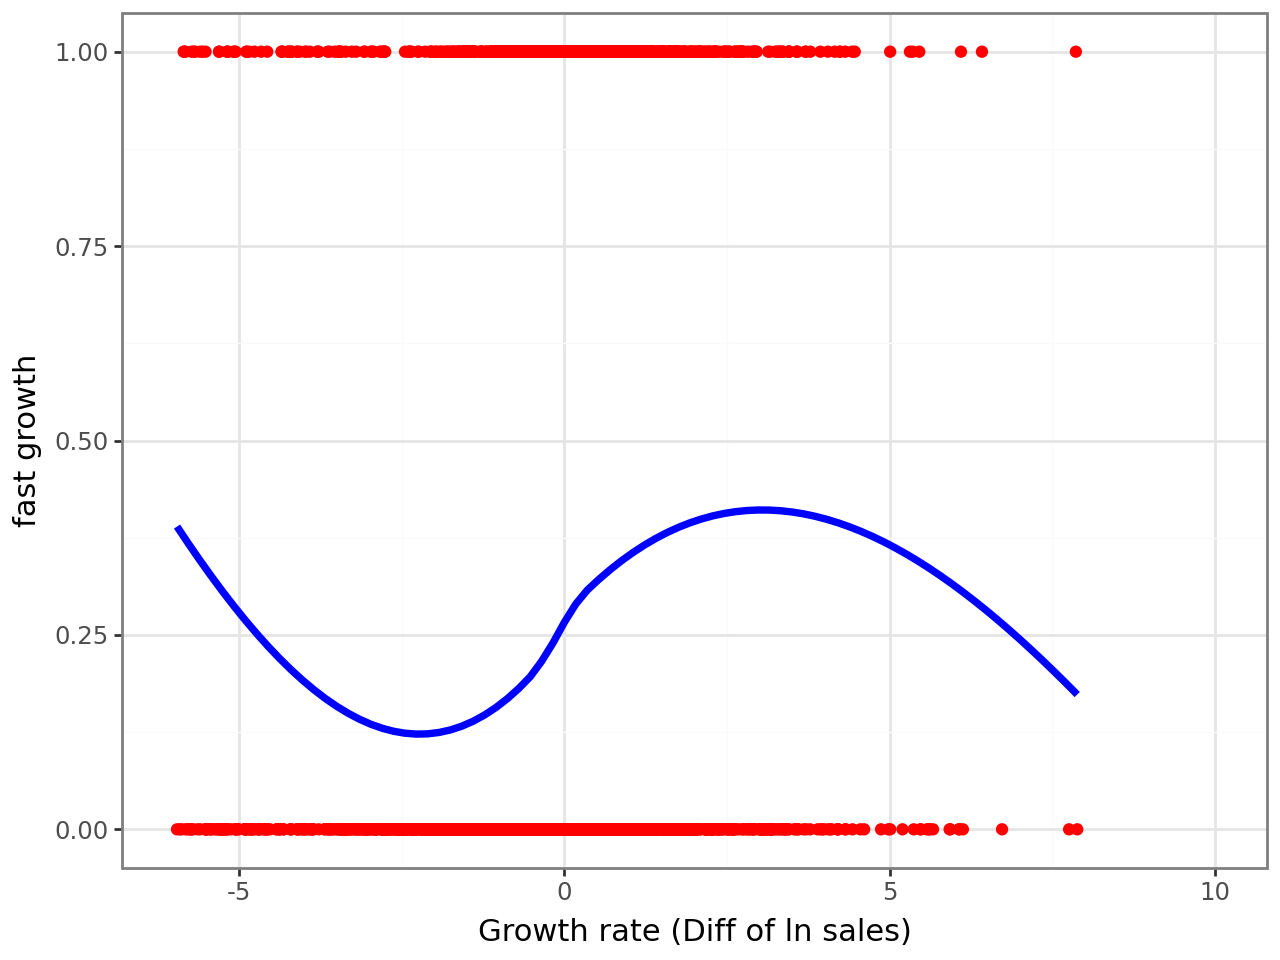

In [121]:
breaks = np.arange(-5, 11, 5)  # Equivalent to seq(-5, 10, by=5) in R

(
    ggplot(data, aes(x="d1_sales_mil_log", y="fast_growth"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="fast growth")
    + scale_x_continuous(limits=(-6, 10), breaks=breaks)  # Use np.arange for breaks
    + theme_bw()
)

In [122]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [123]:
# ===========================================
# 🔹 1️⃣ Create Financial Ratios
# ===========================================


# Profitability Ratios
data['roa'] = data['profit_loss_year'] / data['total_assets_bs']  # Return on Assets
data['roe'] = data['profit_loss_year'] / data['share_eq']  # Return on Equity
data['gross_margin'] = (data['sales'] - data['material_exp']) / data['sales']  # Gross Margin

# Liquidity & Solvency Ratios
data['current_ratio'] = data['curr_assets'] / data['curr_liab']  # Current Ratio
data['debt_to_equity'] = data['curr_liab'] / data['share_eq']  # Debt-to-Equity Ratio

# Leverage & Growth Ratios
data['asset_turnover'] = data['sales'] / data['total_assets_bs']  # Asset Turnover Ratio
data['revenue_per_employee'] = data['sales'] / data['labor_avg_mod']  # Revenue per Employee

# Handle infinite or missing values in ratios
ratio_cols = ['roa', 'roe', 'gross_margin', 'current_ratio', 'debt_to_equity', 'asset_turnover', 'revenue_per_employee']
data[ratio_cols] = data[ratio_cols].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
data[ratio_cols] = data[ratio_cols].fillna(0)  # Replace NaNs with 0

In [124]:
# ===========================================
# 🔹 2️⃣ Create Interaction Terms
# ===========================================

# Ensure categorical variables are converted to numerical before multiplication
data['foreign_management'] = data['foreign_management'].astype(float)  # Convert to numeric
data['ind2_cat'] = data['ind2_cat'].astype(float)  # Convert to numeric
data['debt_to_equity'] = data['debt_to_equity'].astype(float)  # Convert to numeric

# Now create interaction terms
data['age_x_ceo_age'] = data['age'] * data['ceo_age']  # Firm Age x CEO Age
data['foreign_x_industry'] = data['foreign_management'] * data['ind2_cat']  # Foreign Management x Industry
data['debt_x_profit'] = data['debt_to_equity'] * data['profit_growth']  # Leverage x Profitability

In [125]:
# ===========================================
# 🔹 3️⃣ Create Lagged Features (if past years exist)
# ===========================================
# Sort by company ID and year
data = data.sort_values(by=['comp_id', 'year'])

# Create Lagged Features
data['lagged_sales_growth'] = data.groupby('comp_id')['d1_sales_mil_log'].shift(1)  # Sales growth from previous year
data['lagged_profit_growth'] = data.groupby('comp_id')['profit_growth'].shift(1)  # Profit growth from previous year

# Fill missing lagged values with 0 (assuming new firms have no previous growth)
data[['lagged_sales_growth', 'lagged_profit_growth']] = data[['lagged_sales_growth', 'lagged_profit_growth']].fillna(0)

In [126]:
# ===========================================
# 🔹 4️⃣ Winsorization (Clip extreme values)
# ===========================================

# Define Winsorization limits
winsor_limits = {
    'profit_loss_year': (0.01, 0.99),
    'roa': (0.01, 0.99),
    'roe': (0.01, 0.99),
    'gross_margin': (0.01, 0.99),
    'current_ratio': (0.01, 0.99),
    'debt_to_equity': (0.01, 0.99),
    'asset_turnover': (0.01, 0.99),
}

# Apply winsorization
for col, (lower, upper) in winsor_limits.items():
    lower_limit = data[col].quantile(lower)
    upper_limit = data[col].quantile(upper)
    data[col] = np.clip(data[col], lower_limit, upper_limit)

In [127]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [128]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()

count    15910.000000
mean         9.270019
std          6.790786
min          0.000000
25%          3.000000
50%          8.000000
75%         15.000000
max         29.000000
Name: age, dtype: float64

In [129]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

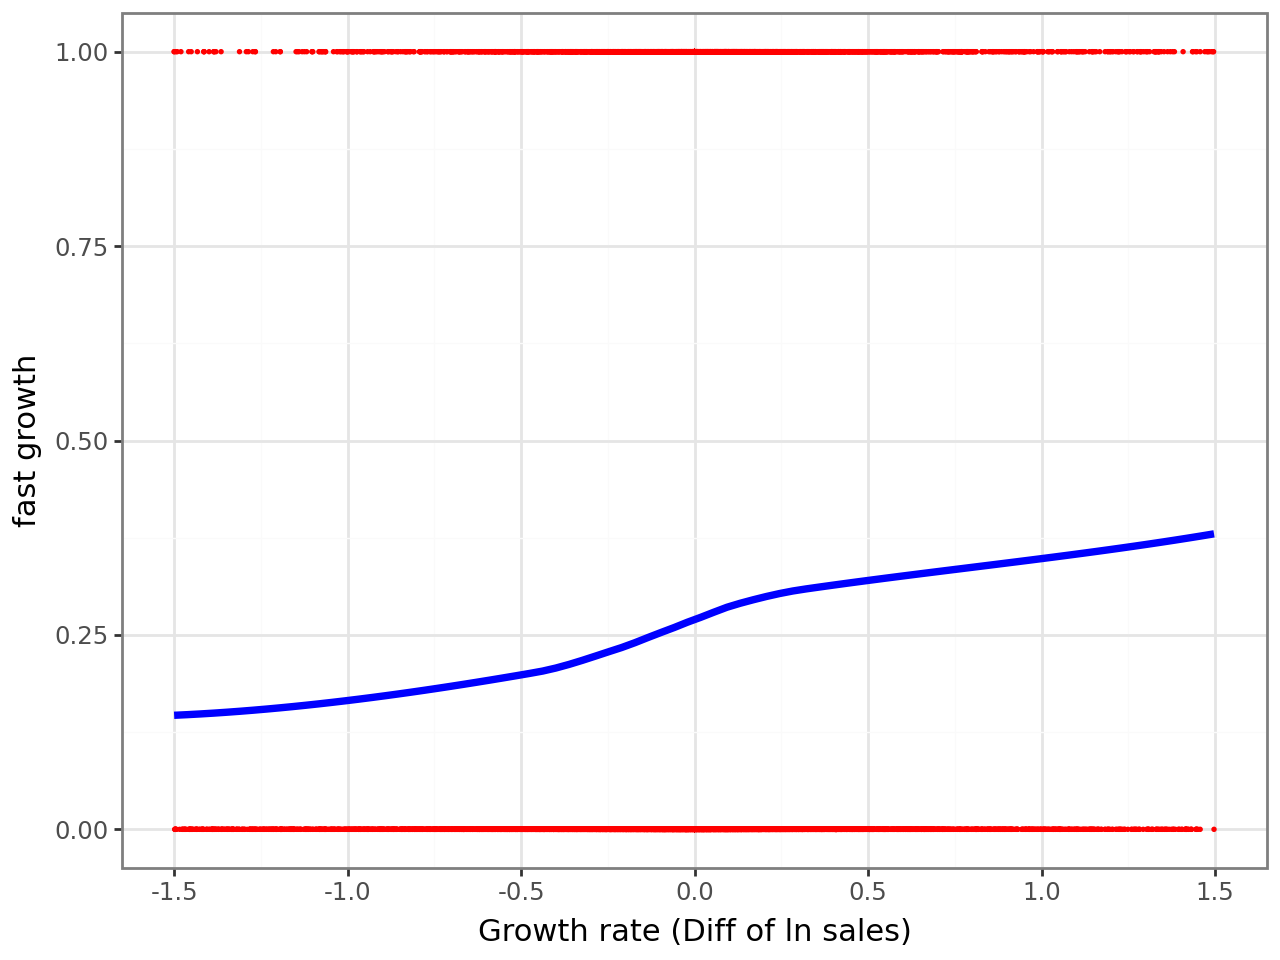

In [130]:
breaks = np.arange(-1.5, 1.6, 0.5)  # Equivalent to seq(-1.5, 1.5, by=0.5) in R

(
    ggplot(data, aes(x="d1_sales_mil_log", y="fast_growth"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="fast growth")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=breaks)  # Use numpy for breaks
    + theme_bw()
)

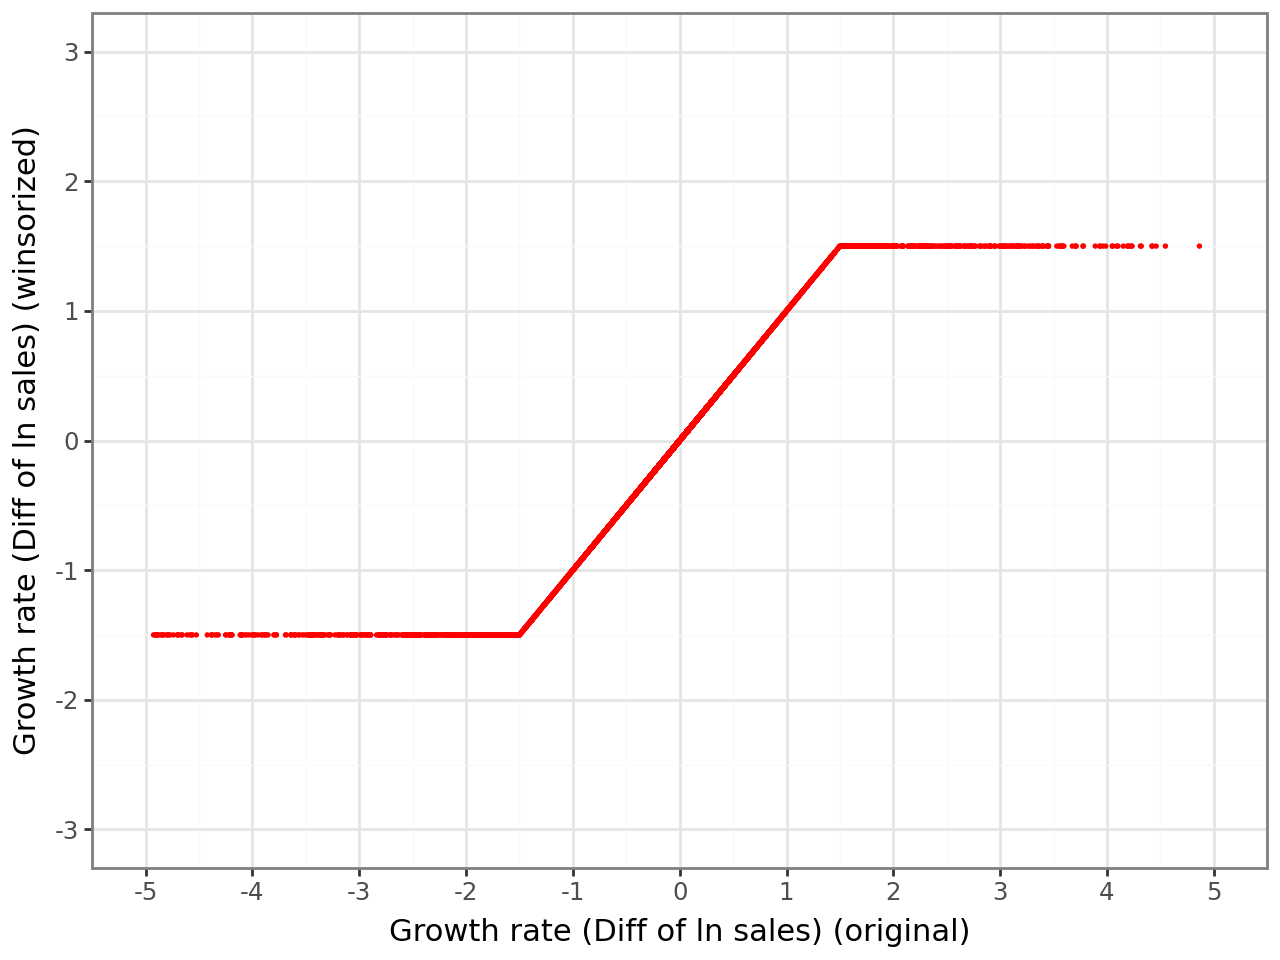

In [131]:
# Define axis breaks using numpy (Python equivalent of seq in R)
x_breaks = np.arange(-5, 6, 1)  # Equivalent to seq(-5, 5, by=1) in R
y_breaks = np.arange(-3, 4, 1)  # Equivalent to seq(-3, 3, by=1) in R

# Create the plot
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=x_breaks)  # Use numpy for x-axis breaks
    + scale_y_continuous(limits=(-3, 3), breaks=y_breaks)  # Use numpy for y-axis breaks
    + theme_bw()
)

In [132]:
data.to_csv(data_out + "bisnode_firms_clean.csv", index=False)

## Predicting firm exit

In [134]:
path = os.path.join('da_data_repo', 'bisnode-firms', 'bisnode_firms_clean.csv')
# this will produce a path with the right syntax for your operating system
path

'da_data_repo\\bisnode-firms\\bisnode_firms_clean.csv'

In [135]:
# DATA IMPORT - FROM FILE
df = pd.read_csv(path)

In [136]:
df.columns.tolist()

['year',
 'comp_id',
 'begin',
 'end',
 'amort',
 'curr_assets',
 'curr_liab',
 'extra_exp',
 'extra_inc',
 'extra_profit_loss',
 'fixed_assets',
 'inc_bef_tax',
 'intang_assets',
 'inventories',
 'liq_assets',
 'material_exp',
 'personnel_exp',
 'profit_loss_year',
 'sales',
 'share_eq',
 'subscribed_cap',
 'tang_assets',
 'D',
 'balsheet_flag',
 'balsheet_length',
 'balsheet_notfullyear',
 'founded_year',
 'exit_year',
 'ceo_count',
 'foreign',
 'female',
 'birth_year',
 'inoffice_days',
 'gender',
 'origin',
 'nace_main',
 'ind2',
 'ind',
 'urban_m',
 'region_m',
 'founded_date',
 'exit_date',
 'status_alive',
 'default',
 'ln_sales',
 'sales_mil',
 'sales_mil_log',
 'd1_sales_mil_log',
 'age',
 'new',
 'profit_growth',
 'fast_growth',
 'ind2_cat',
 'age2',
 'foreign_management',
 'gender_m',
 'm_region_loc',
 'flag_asset_problem',
 'total_assets_bs',
 'extra_exp_pl',
 'extra_inc_pl',
 'extra_profit_loss_pl',
 'inc_bef_tax_pl',
 'inventories_pl',
 'material_exp_pl',
 'profit_loss_ye

In [137]:
# Raw Financial Variables
rawvars = [
    "curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss",
    "fixed_assets", "inc_bef_tax", "intang_assets", "inventories", "liq_assets",
    "material_exp", "personnel_exp", "profit_loss_year", "sales", "share_eq",
    "subscribed_cap"
]

# Data Quality Flags
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

# Engineered Financial Variables
engvar = [
    "total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
    "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
    "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
    "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl",
    "roa", "roe", "gross_margin", "current_ratio", "debt_to_equity", "asset_turnover",
    "revenue_per_employee"
]

# Quadratic Financial Terms
engvar2 = [
    "extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad", "share_eq_bs_quad"
]

# Flag Variables (auto-generated)
engvar3 = []
for col in df.columns:
    if col.endswith(('flag_low', 'flag_high', 'flag_error', 'flag_zero')):
        engvar3.append(col)

# Growth-Related Variables
d1 = [
    "d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log",
    "lagged_sales_growth", "lagged_profit_growth"
]

# CEO & HR-Related Variables
hr = [
    "female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
    "flag_miss_ceo_age", "ceo_young", "labor_avg_mod",
    "flag_miss_labor_avg", "foreign_management"
]

# Interaction Terms
interaction_terms = [
    "age_x_ceo_age", "foreign_x_industry", "debt_x_profit"
]

In [138]:
df.ind2_cat.value_counts().sort_index()

ind2_cat
26.0     836
27.0     506
28.0    1517
29.0     219
30.0     129
33.0    1466
55.0    1872
56.0    9365
Name: count, dtype: int64

In [139]:
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)", df, return_type="dataframe")

In [140]:
ind2_catmat

,C(ind2_cat)[26.0],C(ind2_cat)[27.0],C(ind2_cat)[28.0],C(ind2_cat)[29.0],C(ind2_cat)[30.0],C(ind2_cat)[33.0],C(ind2_cat)[55.0],C(ind2_cat)[56.0]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
15905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15906,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15907,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15908,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [141]:
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

In [142]:
df.year.value_counts().sort_index()

year
2012    15910
Name: count, dtype: int64

In [143]:
df.region_m.value_counts()

region_m
Central    9407
East       4020
West       2483
Name: count, dtype: int64

In [144]:
m_region_locmat = patsy.dmatrix("0 + C(region_m)",df, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(region_m)[Central]'], axis=1)

In [145]:
df.urban_m.value_counts()

urban_m
3.0    6463
1.0    4993
2.0    4454
Name: count, dtype: int64

In [146]:
urban_mmat = patsy.dmatrix("0 + C(urban_m)",df, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [147]:
# Base Model Features
basevars = df[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Model with additional financial and industry features
X2additional_vars = df[[
    "fixed_assets_bs", "share_eq_bs", "curr_liab_bs", "curr_liab_bs_flag_error",
    "curr_liab_bs_flag_high", "age", "foreign_management"
]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Model with firm characteristics (Fix: Properly concatenate lists of DataFrames)
firm = pd.concat([df[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([df[["sales_mil_log", "sales_mil_log_sq"]] , df[engvar], df[d1], firm], axis=1)

# Model with full feature set (Fix: Use `df[columns]` for list variables)
X4 = pd.concat([
    df[["sales_mil_log", "sales_mil_log_sq"]],
    df[engvar], df[d1], df[engvar2], df[engvar3], df[hr], df[qualityvars], firm
], axis=1)

In [148]:
# Interaction Model 1
int1mat = patsy.dmatrix(
    "0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):d1_sales_mil_log_mod \
    + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
    + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod",
    df, return_type="dataframe"
)

# Drop first level to get k-1 dummies
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26]') or col.endswith('C(urban_m)[1]'):
        int1mat = int1mat.drop(columns=[col])

# Interaction Model 2
int2mat = patsy.dmatrix(
    "0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
    + sales_mil_log:foreign_management",
    df, return_type="dataframe"
)

# Full Model with Interactions
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [149]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [150]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([df[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars], firm], axis=1)

In [151]:
y = df['fast_growth']

In [152]:
y.mean()

0.26203645505971085

### Split data into train and holdout

In [154]:
index_train, index_holdout= train_test_split(
    df.index.values, train_size=round(0.8*len(df.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [155]:
print('Total')
print(df['default'].value_counts(normalize=True), '\n')
print('Train')
print(df.iloc[index_train]['default'].value_counts(normalize=True), '\n')
print('Holdout')
print(df.iloc[index_holdout]['default'].value_counts(normalize=True), '\n')

Total
default
0    0.859082
1    0.140918
Name: proportion, dtype: float64 

Train
default
0    0.858815
1    0.141185
Name: proportion, dtype: float64 

Holdout
default
0    0.860151
1    0.139849
Name: proportion, dtype: float64 



### Predictions using cross-validations

#### specify cross-validation method

In [158]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20250224)

#### Logistic regression

In [160]:
# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

In [161]:
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

In [162]:
for i in range(len(logit_model_vars)):
    print(datetime.datetime.now(), f'Running regression {i}...')
    LRCV_brier = LogisticRegressionCV(
        Cs = Cs_value_logit, 
        cv = k, # simply the number of folds
        refit = True, 
        scoring = 'neg_brier_score', 
        solver = "newton-cg", 
        tol=1e-7, 
        random_state = 20250224)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

2025-03-09 22:39:26.057514 Running regression 0...
2025-03-09 22:39:26.195415 Running regression 1...
2025-03-09 22:39:26.454449 Running regression 2...
2025-03-09 22:39:30.261062 Running regression 3...
2025-03-09 22:39:42.120162 Running regression 4...


In [163]:
np.sqrt(-1*logit_models['X5'].scores_[1].flatten())

array([0.42373697, 0.4357424 , 0.42748614, 0.43228078, 0.42065804])

In [164]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5
0,0.428933,0.428364,0.431556,0.423631,0.423737
1,0.441671,0.441238,0.442126,0.434232,0.435742
2,0.434291,0.433435,0.434202,0.428098,0.427486
3,0.441651,0.440528,0.440521,0.434470,0.432281
4,0.427260,0.426962,0.430131,0.419429,0.420658


#### Lasso logit

In [166]:
normalized_logitvars = pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns = logitvars.columns

In [167]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]

In [168]:
logLasso = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', # L1 makes it lasso
    cv = k, 
    refit = True, 
    scoring = 'accuracy', 
    solver = 'liblinear',
    random_state = 20250224)

In [169]:
%%time
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

CPU times: total: 1min 11s
Wall time: 1min 16s


In [170]:
cv_summary_lasso = cv_summary(lambdas, Cs_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000982,0.740336
1,0.046416,0.002116,0.740336
2,0.021544,0.004558,0.740258
3,0.010000,0.009821,0.743950
4,0.004642,0.021158,0.743793
5,0.002154,0.045584,0.744658
6,0.001000,0.098209,0.744500
7,0.000464,0.211584,0.743558
8,0.000215,0.455844,0.742458
9,0.000100,0.982087,0.742615


In [171]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]
best_lambda

0.002154434690031887

Training for ***Brier-score*** (aka RMSE)

In [173]:
#refit with negative brier score so we have RMSE values for the same cv split

logLasso_brier = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', 
    cv = k, 
    refit = True, 
    scoring = 'neg_brier_score', 
    solver = "liblinear", 
    random_state = 20250224)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [174]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

In [175]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.428933,0.428364,0.431556,0.423631,0.423737,0.421654
1,0.441671,0.441238,0.442126,0.434232,0.435742,0.432808
2,0.434291,0.433435,0.434202,0.428098,0.427486,0.424578
3,0.441651,0.440528,0.440521,0.434470,0.432281,0.432339
4,0.427260,0.426962,0.430131,0.419429,0.420658,0.417609


### AUC using no loss fn

In [177]:
CV_AUC_folds = dict()

In [178]:
%%time
for i in range(len(logit_model_vars)):
    print(datetime.datetime.now(), f'Running regression {i}...')
    LRCV_auc = LogisticRegressionCV(
        Cs = Cs_value_logit, 
        cv = k, 
        refit = True, 
        scoring = 'roc_auc', 
        solver= "newton-cg", 
        tol = 1e-7, 
        random_state = 20250224)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

2025-03-09 22:42:46.300545 Running regression 0...
2025-03-09 22:42:46.450020 Running regression 1...
2025-03-09 22:42:46.715913 Running regression 2...
2025-03-09 22:42:50.282202 Running regression 3...
2025-03-09 22:43:01.276743 Running regression 4...
CPU times: total: 43 s
Wall time: 45.3 s


In [179]:
%%time
#refit with AUC so we have AUC values for the same cv split

logLasso_auc = LogisticRegressionCV(
    Cs=Cs_values, 
    penalty='l1', # this makes it lasso
    cv=k, 
    refit=True, scoring='roc_auc', 
    solver="liblinear", 
    random_state = 20250224)

logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

CPU times: total: 1min 14s
Wall time: 1min 20s


In [180]:
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

In [181]:
for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

In [182]:
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [185]:
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.434761,0.585305
X2,18.0,0.434105,0.589282
X3,44.0,0.435707,0.579027
X4,87.0,0.427972,0.637138
X5,179.0,0.427981,0.633801
LASSO,94.0,0.425798,0.648837


Take best model and estimate RMSE on holdout
X4, X5 and LASSO are practically the same - go with the simplest model.

The `predict_proba` method returns *probababilites*, as opposed to the `predict` method (see below), which returns *classes* (trues and falses). 

In [188]:
best_model = logit_models['X4']
best_model_X_holdout = X4.iloc[index_holdout]
logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.433

### AUC using a loss function

In [192]:
FP = 1
FN = 10
cost = FN/FP

# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)
print(f'Prevelance: {prevelance:,.3f}')
print(f'Simple best threshold estimation: {FP/(FP+FN):,.3f}.')

Prevelance: 0.260
Simple best threshold estimation: 0.091.


In [193]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20250224) 

In [194]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    
    fold = 0
    
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
    
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)

        # this is where we pick the best threshold for minimal loss at each model for every single fold
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                    ),
                    thresholds
                )
            )
            , key=lambda i: i[0], reverse=True)[0][1]
        
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()

        # expected loss for each model for every single fold
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    # best threshold and expected loss for each model (averaging out the folds)
    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # best threshold and expected loss for each model for fold5 ONLY
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [195]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()

**Get expected loss on holdout**

In [197]:
best_logit_optimal_treshold = best_thresholds_cv["X4"]
best_logit_optimal_treshold

0.09965143707531052

In [198]:
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.727

In [202]:
# Upgrading Loss Function

In [203]:
# 1. Weighted Loss Function:

In [204]:
def weighted_loss(y_true, y_pred, cost_fn=10, cost_fp=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    loss = (fp * cost_fp + fn * cost_fn) / len(y_true)
    return loss

In [206]:
# 2. Incorporating Class Imbalance

In [207]:
def imbalanced_weighted_loss(y_true, y_pred, cost_fn=10, cost_fp=1, prevalence=None):
    if prevalence is None:
        prevalence = y_true.sum() / len(y_true)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    loss = (fp * cost_fp * (1 - prevalence) + fn * cost_fn * prevalence) / len(y_true)
    return loss

In [209]:
# 3. Probabilistic Loss

In [212]:
from sklearn.metrics import log_loss

def probabilistic_loss(y_true, y_pred):
    return log_loss(y_true, y_pred)

### Prediction with random forest 

In [223]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

In [224]:
rfvars_train.columns

Index(['sales_mil', 'd1_sales_mil_log', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
       'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
       'material_exp', 'personnel_exp', 'profit_loss_year', 'sales',
       'share_eq', 'subscribed_cap', 'female', 'ceo_age', 'flag_high_ceo_age',
       'flag_low_ceo_age', 'flag_miss_ceo_age', 'ceo_young', 'labor_avg_mod',
       'flag_miss_labor_avg', 'foreign_management', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'age', 'age2', 'new',
       'C(ind2_cat)[27.0]', 'C(ind2_cat)[28.0]', 'C(ind2_cat)[29.0]',
       'C(ind2_cat)[30.0]', 'C(ind2_cat)[33.0]', 'C(ind2_cat)[55.0]',
       'C(ind2_cat)[56.0]', 'C(region_m)[East]', 'C(region_m)[West]',
       'C(urban_m)[2.0]', 'C(urban_m)[3.0]'],
      dtype='object')

### Probability forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the `max_samples` parameter if `bootstrap = True` (default), otherwise the whole dataset is used to build each tree.
- `max_features`: number of features to consider when looking for the best split
- `min_samples_fit`: the minimum number of samples required`to split an internal node

In [226]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [227]:
prob_forest = RandomForestClassifier(
    random_state=20250224, 
    n_estimators=50, # this should be higher, but it is kept low in order to control runtime on class
    oob_score=True)

prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv = 5, 
    refit='accuracy', # Refit an estimator using the best found parameters on the whole dataset.
                      # For multiple metric evaluation, this needs to be a str denoting the scorer 
                      # that would be used to find the best parameters for refitting the estimator at the end.
    scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1)

In [228]:
%%time
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

CPU times: total: 2 s
Wall time: 14 s


In [229]:
prob_forest_fit.cv_results_

{'mean_fit_time': array([2.4348031 , 2.24336376, 2.54104195, 2.62555337, 3.05056705,
        2.33302221]),
 'std_fit_time': array([0.15962166, 0.13389239, 0.09421563, 0.1856092 , 0.31361281,
        0.03994075]),
 'mean_score_time': array([0.08515873, 0.08557916, 0.07576132, 0.07693105, 0.07206693,
        0.05190983]),
 'std_score_time': array([0.01310754, 0.01482499, 0.00175268, 0.0047938 , 0.00271097,
        0.00821227]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[5, 5, 6, 6, 7, 7],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[11, 16, 11, 16, 11, 16],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'pa

In [231]:
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5
cv_accuracy

array([0.75518517, 0.75557816, 0.75573499, 0.75534235, 0.75424203,
       0.756521  ])

In [232]:
prob_forest_fit.best_score_

0.7565210037085794

In [233]:
cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5
cv_auc

array([0.69092826, 0.69551816, 0.69699275, 0.69649311, 0.69721365,
       0.70067268])

In [234]:
cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5
cv_rmse

array([0.41732484, 0.41604507, 0.41569077, 0.41601283, 0.41592984,
       0.41506623])

In [236]:
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [237]:
prob_forest_cv_results.style.format(
    {
        'cv_accuracy': '{:.5f}',
        'cv_auc': '{:.5f}',
        'cv_rmse': '{:.5f}'
    }
)

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.75519,0.69093,0.41732
1,5,16,0.75558,0.69552,0.41605
2,6,11,0.75573,0.69699,0.41569
3,6,16,0.75534,0.69649,0.41601
4,7,11,0.75424,0.69721,0.41593
5,7,16,0.75652,0.70067,0.41507


In [238]:
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

In [239]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_max_features) & 
    (prob_forest_cv_results.min_samples_split == best_min_sample_split)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

CV_RMSE_folds_rf_p = list()

# Get Fold Level RMSE and AUC
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)

CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()

for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)

CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5,LASSO,rf_p
0,0.584463,0.587532,0.568428,0.627772,0.625725,0.639216,0.696335
1,0.578787,0.581041,0.574634,0.635816,0.625448,0.646504,0.698282
2,0.584902,0.586326,0.580285,0.628924,0.626353,0.645103,0.701379
3,0.583882,0.593624,0.592737,0.640783,0.645784,0.649100,0.700081
4,0.594490,0.597888,0.579051,0.652396,0.645696,0.664261,0.707286


In [241]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    print(f'{datetime.datetime.now()}: fold {fold}...') 
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(
        random_state=20250224, 
        n_estimators=50, # make it higher in practice (default being 100)
        oob_score=True,
        criterion = 'gini', 
        max_features = best_max_features, min_samples_split = best_min_sample_split
    )
    
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

2025-03-09 22:45:12.834150: fold 0...
2025-03-09 22:45:14.251940: fold 1...
2025-03-09 22:45:15.866234: fold 2...
2025-03-09 22:45:17.426714: fold 3...
2025-03-09 22:45:19.045611: fold 4...


In [243]:
for f, t in enumerate(best_thresholds):
    print(f'Fold: {f}, best threshold: {t:,.4f}.')

Fold: 0, best threshold: 0.0723.
Fold: 1, best threshold: 0.1366.
Fold: 2, best threshold: 0.0648.
Fold: 3, best threshold: 0.0836.
Fold: 4, best threshold: 0.1005.


In [244]:
for f, l in enumerate(expected_loss):
    print(f'Fold: {f}, smalles loss: {l:,.4f}.')

Fold: 0, smalles loss: 0.7258.
Fold: 1, smalles loss: 0.6681.
Fold: 2, smalles loss: 0.7357.
Fold: 3, smalles loss: 0.7010.
Fold: 4, smalles loss: 0.7128.


In [245]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_rf

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,631.0,1914.0,631,1914,2545,inf
1,0.0,1.0,630.0,1914.0,631,1914,2545,0.846839
2,0.0,2.0,629.0,1914.0,631,1914,2545,0.791593
3,1.0,2.0,629.0,1913.0,631,1914,2545,0.787354
4,1.0,4.0,627.0,1913.0,631,1914,2545,0.768038
...,...,...,...,...,...,...,...,...
859,1869.0,629.0,2.0,45.0,631,1914,2545,0.049286
860,1869.0,630.0,1.0,45.0,631,1914,2545,0.047240
861,1893.0,630.0,1.0,21.0,631,1914,2545,0.037246
862,1893.0,631.0,0.0,21.0,631,1914,2545,0.037228


In [248]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [249]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.415,0.701,0.092,0.1,0.709,0.713


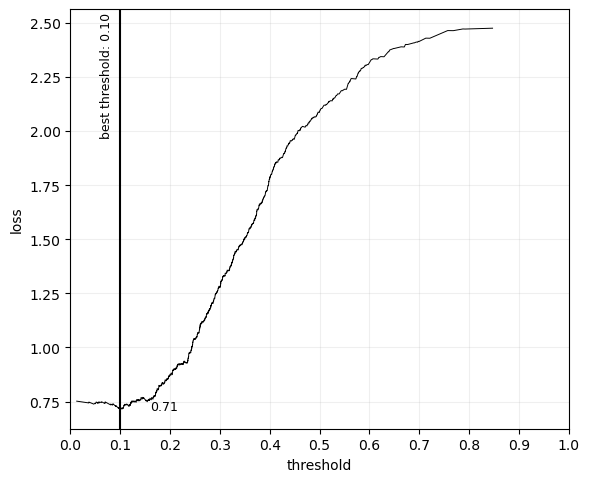

In [251]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf);

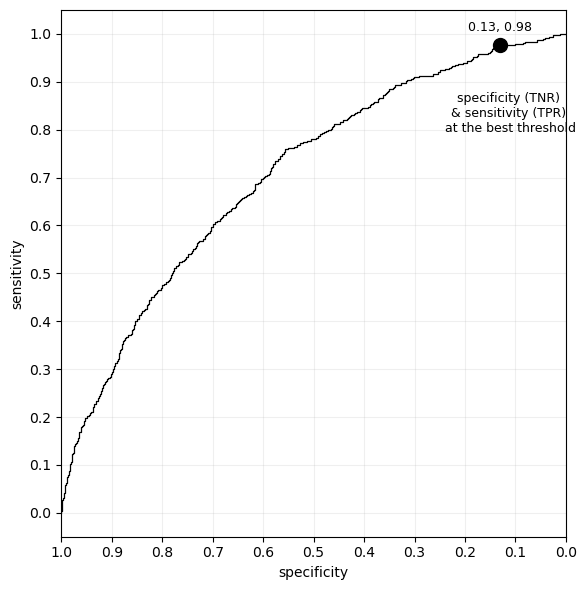

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='specificity', ylabel='sensitivity'>)

In [252]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

In [253]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.419

In [255]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.702

In [266]:
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.724

In [267]:
import datetime
print(datetime.datetime.now())

2025-03-09 22:45:26.688605


In [268]:
prob_forest_best_fold.predict(rfvars_holdout)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [270]:
prob_forest_best_fold.predict_proba(rfvars_holdout)

array([[0.7468676 , 0.2531324 ],
       [0.51826753, 0.48173247],
       [0.84599558, 0.15400442],
       ...,
       [0.83081265, 0.16918735],
       [0.59358127, 0.40641873],
       [0.64120076, 0.35879924]])

In [271]:
nvars['rf_p'] = len(rfvars.columns)

In [273]:
summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

In [274]:
summary_results.style.format(
    {
        'CV threshold': '{:.4f}',
        'CV AUC': '{:.4f}',
        'CV RMSE': '{:.4f}',
        'CV expected Loss': '{:.4f}'
    }
)

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,11,0.4348,0.5853,0.1070,0.7317
1,X2,18,0.4341,0.5893,0.0891,0.7351
2,X3,44,0.4357,0.5790,0.0830,0.7381
3,X4,87,0.4280,0.6371,0.0997,0.7322
4,X5,179,0.4280,0.6338,0.0816,0.7319
5,LASSO,94,0.4258,0.6488,0.0838,0.7208
6,rf_p,44,0.4151,0.7007,0.0915,0.7087
